In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
np.random.seed(42)
from PIL import Image # to handle images
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import ttest_ind
from keras.models import Sequential
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


## functions

In [89]:
# load images and process to the format

def augment_image(images4D):
    ori_length = images4D.shape[0]
    images4DAug = np.concatenate( (images4D, images4D, images4D, images4D), axis = 0 ) # quadruple it
    images4DAug[ori_length*2:,:,:,:] = 255 - images4DAug[ori_length*2:,:,:,:] #invert the last half
    images4DAug[ori_length:ori_length*2,:,:,:] = np.flip(images4DAug[ori_length:ori_length*2,:,:,:], axis = 2) # flip the second quarter
    images4DAug[ori_length*3:ori_length*4,:,:,:] = np.flip(images4DAug[ori_length*3:ori_length*4,:,:,:], axis = 2)# flip the fourth quarter
    return images4DAug

def render_noisy(images4D, p=0.2):
    na,nb,nc,nd = images4D.shape
    for a in range(na):
        for b in range(nb):
            for c in range(nc):
                r = np.random.binomial(1,p)
                if r == 1:
                    images4D[a,b,c,0] = 255-images4D[a,b,c,0]
                    images4D[a,b,c,1] = 255-images4D[a,b,c,1]
                    images4D[a,b,c,2] = 255-images4D[a,b,c,2]
    return images4D

In [107]:
images = glob("D:/paredolia/noFacesInTheWild/data/wtface/small/*.jpg")

quantile_alphas = np.linspace(0.25,0.75,num=9) # define the alphas of the quantiles
quantiles = np.quantile(img,quantile_alphas) # get the values (z) of the quantiles
print(quantiles)

Train = np.ndarray((len(images)*len(quantiles),43,32,3))

counter = 0
for j, file in enumerate(images):
    try:
        img = cv2.imread(file,0) # load
        img = cv2.resize(img,(32,43)) # reshape it
        img

        for q in quantiles:
            img2 = cv2.threshold(img,q,255,cv2.THRESH_BINARY)
            img2 = cv2.cvtColor(img2[1],cv2.COLOR_GRAY2RGB) # to rgb #np.float32
            
            #print(np.min(img2))
            Train[counter,:,:,:] = img2
            counter += 1
            
    except:
        print("error in image #"+str(j))

Train = augment_image(Train) # invert + mirror on vertical axis
Train = np.concatenate( (Train, np.flip(Train, axis = 1)), axis = 0 ) # add a horizontally flipped control condition ( no pareidolia )
X = Train
y = np.repeat([1,0],Train.shape[0]/2)

#Train = render_noisy(Train, p = 0.4)

[ 69.      75.      80.      89.     109.     132.     149.     177.3125
 185.    ]


W0915 15:50:08.053850  9808 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


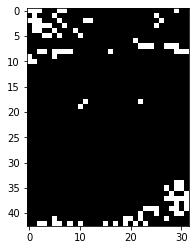

W0915 15:50:08.212961  9808 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


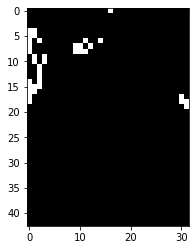

In [100]:
for j in range(2):
    i = np.random.randint(len(Train[:,0,0,0]))
    plt.imshow(Train[i,:,:,:]); plt.show()

In [108]:
Train.shape

(87624, 43, 32, 3)

In [109]:
len(y)

87624

In [137]:
# create data generator
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=15, ###  changed this
    width_shift_range=0.1, ### changed this
    height_shift_range=0.1, ### changed this
    brightness_range=None,
    shear_range=0.1, ### changed this
    zoom_range=0.1, ### changed this
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0, 
    dtype=None,)

In [138]:
# create iterator
X_train, X_test, y_train, y_test = train_test_split(Train, to_categorical(y), test_size = 0.25, random_state = 42)

it = datagen.flow(X_train, y_train, batch_size=32)

In [139]:
def transfer_learning():
    # get mobilenet and add some layers at the end, 2 output classes
    model = Sequential()
    model.add(MobileNet(weights='imagenet',include_top=False, input_shape = (43, 32, 3) )) #imports the mobilenet model and discards the last 1000 neuron layer.
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax')) # sigmoid
    #model.summary()
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # adam
    return model

In [140]:
model = transfer_learning()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # adam #categorical_crossentropy
model.fit_generator(it, epochs=25, steps_per_epoch=1500) #, 
# 25 epochs should already lead to conversion

c:\users\roman\anaconda3\envs\keras-gpu\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/25
1500/1500 [==============================] - 121s 81ms/step - loss: 0.7184 - acc: 0.5193
Epoch 2/25
1500/1500 [==============================] - 110s 73ms/step - loss: 0.6741 - acc: 0.5833
Epoch 3/25
1500/1500 [==============================] - 101s 67ms/step - loss: 0.6572 - acc: 0.6073
Epoch 4/25
1500/1500 [==============================] - 102s 68ms/step - loss: 0.6553 - acc: 0.6110
Epoch 5/25
1500/1500 [==============================] - 109s 73ms/step - loss: 0.6526 - acc: 0.6117
Epoch 6/25
1500/1500 [==============================] - 111s 74ms/step - loss: 0.6554 - acc: 0.6104
Epoch 7/25
1500/1500 [==============================] - 111s 74ms/step - loss: 0.6408 - acc: 0.6301
Epoch 8/25
1500/1500 [==============================] - 106s 70ms/step - loss: 0.6331 - acc: 0.6370
Epoch 9/25
1500/1500 [==============================] - 99s 66ms/step - loss: 0.6267 - acc: 0.6459
Epoch 10/25
1500/1500 [==============================] - 103s 68ms/step - loss: 0.6202 - acc: 0.6496


In [141]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 79.33%


# load and test the subject data

In [125]:
def predictions_noise(model, X_test):
    predictions = model.predict_proba(X_test)
    facePredictions = predictions[:,1]
    plt.plot(facePredictions)
    plt.show()

def load_labels_and_stim(s, sigma = 1): # s: subject identifier
    # load behavior file
    behaviorFile = 'D:/paredolia/facepareidolia/labels/' + s + 'df.csv'
    df = pd.read_csv(behaviorFile)

    # load stimuli

    files = sorted(glob('D:/paredolia/facepareidolia/stimuli/'+ s +'/' + '*.tif'))

    X = np.ndarray((len(files),43,32,3))
    yn = []
    c = 0
    for j, file in enumerate(files):
        fname = os.path.split(os.path.normpath(file))[-1] # file name without path

        # check if face or noface
        try:
            if df.loc[df['picture'] == fname, 'category'].iloc[0] == "Face":
                yn.append(1)
            elif df.loc[df['picture'] == fname, 'category'].iloc[0] == "noFace":
                yn.append(0)
        except:
            #print(fname  + "not rated !")
            c += 1
            continue
        img = cv2.imread(file,0)
        img = cv2.resize(img,(32,43)) # reshape it
        img = np.flip(img, axis = 0) # faces are upside down
        img = cv2.GaussianBlur(img,(sigma,sigma),0)
        img = cv2.threshold(img,127,255,cv2.THRESH_BINARY) #TTT
        img = cv2.cvtColor(img[1],cv2.COLOR_GRAY2RGB) # to rgb
        img = np.expand_dims(img, 0) # new dimension
        X[j-c,:,:,:] = img.astype("int32")
    X = np.delete(X, list(range(X.shape[0]-c , X.shape[0])), axis = 0) # delete the images which were not rated
    return X, yn

def test_model(model, sigma = 1):
    
    # determine subjects
    subs = glob("D:/paredolia/facepareidolia/stimuli/*")
    subs = [os.path.split(subs[i])[1] for i,s in enumerate(subs)]
    
    # loop over subjects
    allFacePrediction = np.ndarray(1)
    allNoFacePrediction = np.ndarray(1)
    for i,s in enumerate(subs):
        #print('subject ' + s)
        
        # load stimuli and labels
        X, yn = load_labels_and_stim(s, sigma = sigma)
        
        # predict
        predictions = model.predict_proba(X)
        facePredictions = predictions[:,1]
        #plt.plot(facePredictions)
        #plt.show()
        indices_face   = [i for i, x in enumerate(yn) if x == 1]
        indices_noface = [i for i, x in enumerate(yn) if x == 0]
        
        # test significance
        print(ttest_ind(facePredictions[indices_face], facePredictions[indices_noface], equal_var=True))
        allFacePrediction = np.concatenate([allFacePrediction,facePredictions[indices_face]],axis=0)
        allNoFacePrediction = np.concatenate([allNoFacePrediction,facePredictions[indices_noface]],axis=0)
        # test significance for the 100 strongest images
        
    # test significance across subjects !!
    print("across all subjects:")
    print(ttest_ind(allFacePrediction, allNoFacePrediction, equal_var=True))
    
def compare_prediction_similarities(model, sigma = 1):
    
    # determine subjects
    subs = glob("D:/paredolia/facepareidolia/stimuli/*")
    subs = [os.path.split(subs[i])[1] for i,s in enumerate(subs)]
    
    # loop over subjects
    predAllSub = []
    labelAllSub = []
    for i,s in enumerate(subs):
        print('subject ' + s)
        
        # load stimuli and labels
        X, yn = load_labels_and_stim(s, sigma = sigma)
        
        # predict
        predictions = model.predict_proba(X)
        facePredictions = predictions[:,1]
        
        predAllSub.append(facePredictions)
        labelAllSub.append(yn)
        
    return predAllSub, labelAllSub
        

In [ ]:
test_model(model)

Ttest_indResult(statistic=2.548893037502808, pvalue=0.010851532765152983)
Ttest_indResult(statistic=1.0708588987561427, pvalue=0.28431055615935186)
Ttest_indResult(statistic=-2.2285309478698525, pvalue=0.026068577428092488)
Ttest_indResult(statistic=-0.9321994978749331, pvalue=0.3514591177415586)
Ttest_indResult(statistic=0.1626475603786006, pvalue=0.870829129651843)
Ttest_indResult(statistic=1.4690830266571522, pvalue=0.14212603711355962)


In [ ]:
test_model(model, sigma = 2)

In [ ]:
test_model(model, sigma = 3)

In [ ]:
preds, labs = compare_prediction_similarities(model, sigma = 1)

In [ ]:
subs = glob("D:/paredolia/facepareidolia/stimuli/*")
subs = [os.path.split(subs[i])[1] for i,s in enumerate(subs)]

# to tidy df
d = []
sub = []
lab = []
for s, i in enumerate(preds):
    l = labs[s]
    for j,k in zip (i,l):
        d.append(j)
        sub.append(subs[s])
        lab.append(k)
di = {"subject":sub,"face prediction":d,"label":lab}

df = pd.DataFrame(di)
df.head()

sns.stripplot(x="subject", y = "face prediction", data = df, size=2)
#sns.violinplot(x="subject", y = "face prediction", data = df)
#plt.yscale('logit') #log
#plt.yscale('log') #log
sns.violinplot(x="subject", y = "face prediction", data = df)
plt.axhline(y=0.5, color = "black")
plt.ylim(0,1)
#plt.show()
#plt.savefig("./paper/face_predictions.png", dpi=250, transparency = True)